In [0]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q "/content/gdrive/My Drive/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
gdrive/  hvc_annotations.csv  resized/  sample_data/


In [0]:
%tensorflow_version 1.x

import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


from keras.applications import VGG16
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
import seaborn as sns


In [0]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


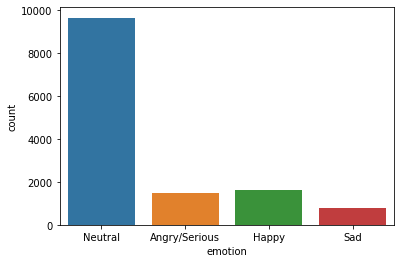

In [0]:
sns.countplot(x='emotion',data=df)
# This shows that the dataset is highly imbalanced for 'emotion' 
#and hence learning emotion would be difficult and would mostly predict 9500/13573=69.99%~70%

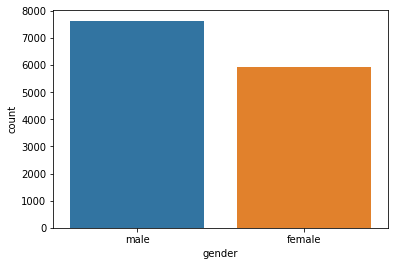

In [0]:
sns.countplot(x='gender',data=df)
# Gender is well balanced with same proportions of male and female

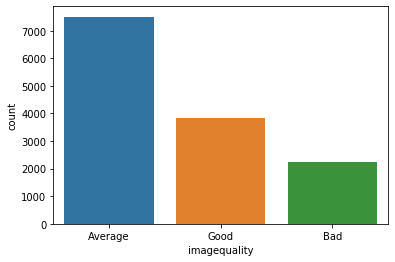

In [0]:
sns.countplot(x='imagequality',data=df)
#Overall ok dataset

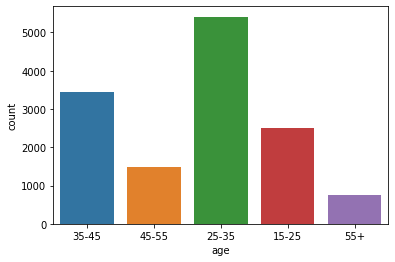

In [0]:
sns.countplot(x='age',data=df)
#Max values are distributed between age 25-35 & 35-45 , rest age group data samples are less.

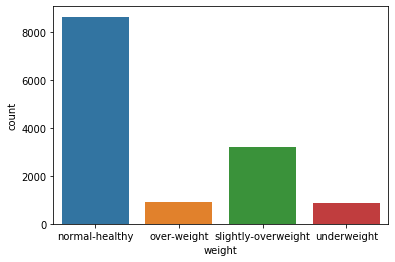

In [0]:
sns.countplot(x='weight',data=df)
#Mostly imbalanced dataset in terms of 'weight', most weight learnt will be for normal-healthy. 8100/13753=59.6%. Examples of over-weight and underweight are too less.

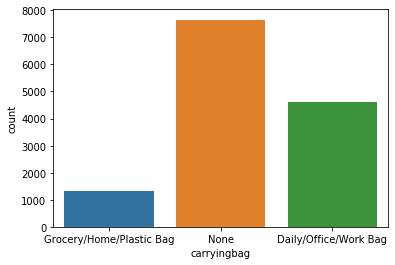

In [0]:
sns.countplot(x='carryingbag',data=df)
# mostly distributed between none and daily work bag, examples of grocery/home bag is too less to learn. Hence average learning possible.

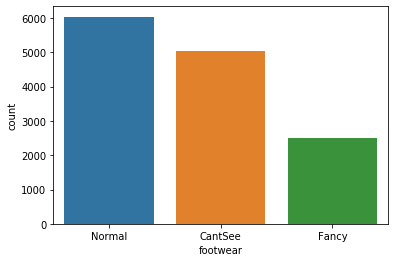

In [0]:
sns.countplot(x='footwear',data=df)
#instances of fancy are 1/3rd the normal footwear. Still Imbalanced.

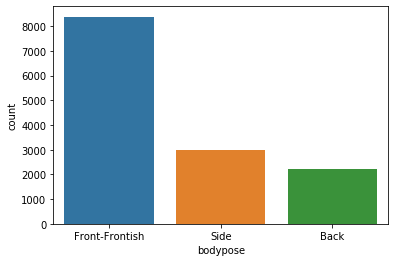

In [0]:
sns.countplot(x='bodypose',data=df)
#Highly Imbalanced as most data shows Front-Frontish as calulated.

In [0]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [0]:
import keras
import numpy as np

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    
    def __init__(self, df, batch_size=32, shuffle=True):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        image = np.stack([cv2.imread(item["image_path"])/255. for _, item in items.iterrows()])
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        return image, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [0]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.2)
train_df.shape, val_df.shape

((10858, 28), (2715, 28))

In [0]:
train_df.head()

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
11992,resized/11994.jpg,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0
2925,resized/2926.jpg,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,1,0,0
10742,resized/10744.jpg,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0
66,resized/67.jpg,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0
4720,resized/4721.jpg,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0


In [0]:
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, batch_size=64)
valid_gen = PersonDataGenerator(val_df, batch_size=64, shuffle=False)

In [0]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

In [0]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
import os

In [0]:
backbone = Sequential()
backbone.add(Convolution2D(16, (3, 3),dilation_rate=(2, 2),input_shape=(224, 224, 3))) #220
backbone.add(BatchNormalization())
backbone.add(Activation('relu'))
backbone.add(Dropout(0.4))
backbone.add(Convolution2D(16, (3, 3),strides=(2,2))) #110
backbone.add(BatchNormalization())
backbone.add(Activation('relu'))
backbone.add(Dropout(0.4))
backbone.add(Convolution2D(32, (3, 3),dilation_rate=(2, 2))) #106
backbone.add(BatchNormalization())
backbone.add(Activation('relu'))
backbone.add(Dropout(0.4))
backbone.add(Convolution2D(32, 3, 3)) #104
backbone.add(BatchNormalization())
backbone.add(Activation('relu'))
backbone.add(Dropout(0.4))
backbone.add(Convolution2D(48, (3, 3),strides=(2,2))) #52
backbone.add(BatchNormalization())
backbone.add(Activation('relu'))
backbone.add(Dropout(0.4))
backbone.add(Convolution2D(48, (3, 3),dilation_rate=(2, 2))) #48
backbone.add(BatchNormalization())
backbone.add(Activation('relu'))
backbone.add(Dropout(0.4))
#backbone.add(Dropout(0.2))
backbone.add(Convolution2D(64, 3, 3)) #46
backbone.add(BatchNormalization())
backbone.add(Activation('relu'))
backbone.add(Dropout(0.4))
backbone.add(Convolution2D(64, (3, 3),strides=(2,2))) #23
backbone.add(BatchNormalization())
backbone.add(Activation('relu'))
backbone.add(Dropout(0.4))
backbone.add(Convolution2D(96, (3, 3),dilation_rate=(2, 2))) #19
backbone.add(BatchNormalization())
backbone.add(Activation('relu'))
backbone.add(Dropout(0.4))
backbone.add(Convolution2D(96, (3, 3),strides=(2,2))) #9
backbone.add(BatchNormalization())
backbone.add(Activation('relu'))
backbone.add(Dropout(0.4))
backbone.add(Convolution2D(128, (3, 3),dilation_rate=(2, 2))) #5
backbone.add(BatchNormalization())
backbone.add(Activation('relu'))
backbone.add(Dropout(0.4))
backbone.add(GlobalAveragePooling2D(name='avg_pool'))

neck = backbone.output

def build_tower(in_layer):
    #neck = Dropout(0.2)(in_layer)
    #neck = Dense(128, activation="relu")(neck)
    #neck = Dropout(0.3)(neck)
    #neck = Dense(128, activation="relu")(neck)
    return neck


def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))


model = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)
model.summary()












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3))`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_1_input (InputLayer)     (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 220, 220, 16) 448         conv2d_1_input[0][0]             
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 220, 220, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 220, 220, 16) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
# losses = {
# 	"gender_output": "binary_crossentropy",
# 	"image_quality_output": "categorical_crossentropy",
# 	"age_output": "categorical_crossentropy",
# 	"weight_output": "categorical_crossentropy",

# }
# loss_weights = {"gender_output": 1.0, "image_quality_output": 1.0, "age_output": 1.0}

from keras.layers import SeparableConv2D,GlobalAveragePooling2D,Conv2D
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
  lr = 1e-3
  if epoch > 140:
    lr = round(0.1 * 1/(1 + 0.319 * epoch), 10)
  elif epoch > 110:
    lr = 1e-3
  elif epoch > 40:
    lr = 1e-3
  elif epoch > 0:
    lr = 1e-2
  
  print('Learning rate: ', lr)
  return lr


opt = SGD(lr=0.001, momentum=0.9)
lr=0.01
model.compile(
    optimizer='adam',
    loss="categorical_crossentropy", 
    # loss_weights=loss_weights, 
    metrics=["accuracy"]
)

In [0]:
# model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=32, epochs=10)
# Prepare model model saving directory.
model_type='Assign5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
gender_filepath = os.path.join(save_dir, "gender.h5")
imgQuality_filepath = os.path.join(save_dir, "imgQuality.h5")
age_filepath = os.path.join(save_dir, "age.h5")
weight_filepath = os.path.join(save_dir, "weight.h5")
bag_filepath = os.path.join(save_dir, "bag.h5")
footwear_filepath = os.path.join(save_dir, "footwear.h5")
pose_filepath = os.path.join(save_dir, "pose.h5")
emotion_filepath = os.path.join(save_dir, "emotion.h5")

gender_checkpoint = ModelCheckpoint(filepath=gender_filepath,
                             monitor='val_gender_output_acc',
                             verbose=1,
                             save_best_only=True)
imgQuality_checkpoint = ModelCheckpoint(filepath=imgQuality_filepath,
                             monitor='val_image_quality_output_acc',
                             verbose=1,
                             save_best_only=True)
age_checkpoint = ModelCheckpoint(filepath=age_filepath,
                             monitor='val_age_output_acc',
                             verbose=1,
                             save_best_only=True)
weight_checkpoint = ModelCheckpoint(filepath=weight_filepath,
                             monitor='val_weight_output_acc',
                             verbose=1,
                             save_best_only=True)
bag_checkpoint = ModelCheckpoint(filepath=bag_filepath,
                             monitor='val_bag_output_acc',
                             verbose=1,
                             save_best_only=True)
footwear_checkpoint = ModelCheckpoint(filepath=footwear_filepath,
                             monitor='val_footwear_output_acc',
                             verbose=1,
                             save_best_only=True)
pose_checkpoint = ModelCheckpoint(filepath=pose_filepath,
                             monitor='val_pose_output_acc',
                             verbose=1,
                             save_best_only=True)
emotion_checkpoint = ModelCheckpoint(filepath=emotion_filepath,
                             monitor='val_emotion_output_acc',
                             verbose=1,
                             save_best_only=True)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

lr_scheduler = LearningRateScheduler(scheduler, verbose=1) #LearningRateScheduler(lr_schedule)

callbacks = [lr_reducer, lr_scheduler]

In [0]:
model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=10, 
    epochs=80,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/80
Learning rate:  0.001

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
168/169 [============================>.] - ETA: 0s - loss: 7.6994 - gender_output_loss: 0.6469 - image_quality_output_loss: 0.9812 - age_output_loss: 1.4108 - weight_output_loss: 0.9692 - bag_output_loss: 0.9163 - footwear_output_loss: 0.9467 - pose_output_loss: 0.9219 - emotion_output_loss: 0.9065 - gender_output_acc: 0.6052 - image_quality_output_acc: 0.5516 - age_output_acc: 0.3969 - weight_output_acc: 0.6413 - bag_output_acc: 0.5597 - footwear_output_acc: 0.5612 - pose_output_acc: 0.6150 - emotion_output_acc: 0.7134